In [1]:
from collections import defaultdict as dd

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gym

In [2]:
env = gym.make('Blackjack-v1', natural=True)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Задание 1
Функция basic_policy описывает самую простую стратегию. 
Если сумму на руках у игрока >= 19, то возвращаем действие "stand", в противном случае "hit".

In [3]:
GAMMA = 0.9
E_GREEDY_PROBS = {
    "hit": [0.1, 0.9],
    "stand": [0.9, 0.1]
}

In [4]:
def basic_policy(state):
  """
    hit - 1
    stand - 0
  """
  sum_hand, dealer, usable_ace = state
  act_probs = E_GREEDY_PROBS['stand'] if sum_hand >= 19 else E_GREEDY_PROBS['hit']
  action = np.random.choice(np.arange(2), p=act_probs)
  return action

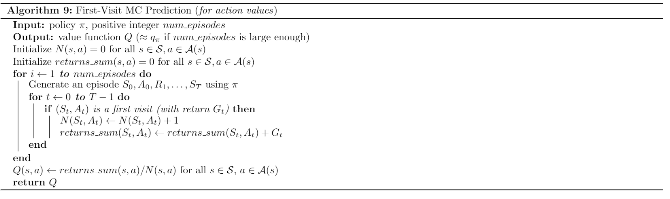

In [5]:
class FirstVisitMonteCarloEvaluator():
  def __init__(self, env, policy):
    self.env = env
    self.policy = policy
    self.state_occurance = dd(lambda: np.zeros(env.action_space.n))
    self.cumm_sum = dd(lambda: np.zeros(env.action_space.n))
    self.Q = dd(lambda: np.zeros(env.action_space.n))

  def play_episode(self):
      episode = []
      state = self.env.reset()
      while True:
          action = self.policy(state)
          next_state, reward, done, _ = self.env.step(action)
          episode.append({
              "state": state,
              "action": action,
              "reward": reward
          })
          state = next_state
          if done:
              break
      return episode

  def update_Q(self, episode):
    visited_states = set()

    for step_idx, step_info in enumerate(episode):
      state, action, reward = step_info['state'], step_info['action'], step_info['reward']
      print(state)
      if state in visited_states:
        print("Visited")
        continue
      visited_states.add(state)
      total_reward = sum([step["reward"] * GAMMA ** idx 
                          for idx, step in enumerate(episode[step_idx:])])
      self.state_occurance[state][action] += 1
      self.cumm_sum[state][action] += total_reward
      self.Q[state][action] = self.cumm_sum[state][action] / self.state_occurance[state][action]

  def evaluate(self, n_episodes):
    for idx in range(n_episodes):
      episode = self.play_episode()
      self.update_Q(episode)

      if idx % 20000 == 0:
        print(f"Episode num {idx=}")
      
    return self.Q

In [ ]:
evaluator = FirstVisitMonteCarloEvaluator(env, basic_policy)
Q_values = evaluator.evaluate(500_000)

Episode num idx=0
Episode num idx=20000
Episode num idx=40000
Episode num idx=60000
Episode num idx=80000
Episode num idx=100000
Episode num idx=120000
Episode num idx=140000
Episode num idx=160000
Episode num idx=180000
Episode num idx=200000
Episode num idx=220000
Episode num idx=240000
Episode num idx=260000
Episode num idx=280000
Episode num idx=300000
Episode num idx=320000
Episode num idx=340000
Episode num idx=360000
Episode num idx=380000
Episode num idx=400000
Episode num idx=420000
Episode num idx=440000
Episode num idx=460000
Episode num idx=480000


In [6]:
def plot_blackjack_values(Q_values):
    def get_Z(x, y, usable_ace):
        if (x, y, usable_ace) in Q_values:
            return Q_values[x, y, usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([get_Z(x, y, usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

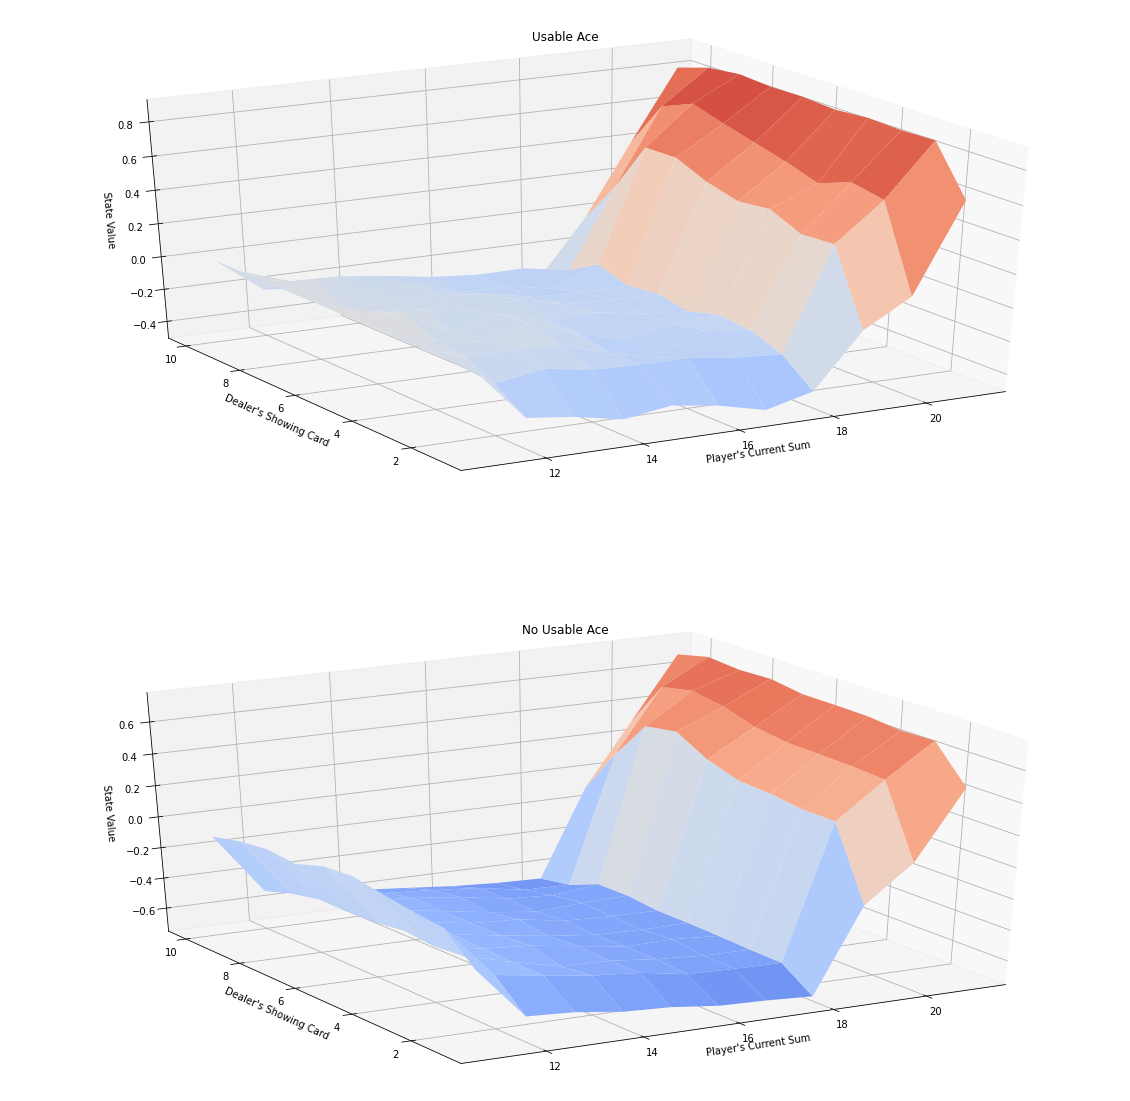

In [ ]:
Q_plot = dict((state,(state[0] >= 19) * (np.dot(E_GREEDY_PROBS['stand'], q)) + (state[0] < 19)*(np.dot(E_GREEDY_PROBS['hit'], q))) \
         for state, q in Q_values.items())
plot_blackjack_values(Q_plot)

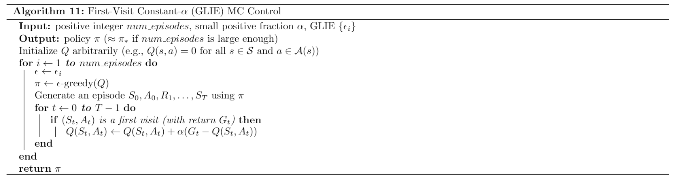

In [7]:
class MonteCarloControl:
  def __init__(self, env):
    self.env = env
    self.alpha = 0.001
    self.eps = 0.9
    self.gamma = 1.0
    self.decay = 0.9
    self.eps_min = 0.01
    self.plot_step = 100_000
    self.rewards_storage = []
    self.Q = dd(lambda: np.zeros(env.action_space.n))
  
  def best_policy(self):
    return dict((state, np.argmax(q)) for state, q in self.Q.items())
  
  def update_Q(self, episode):
    visited_states = set()

    for step_idx, step_info in enumerate(episode):
      state, action, reward = step_info['state'], step_info['action'], step_info['reward']
      if state in visited_states:
        continue
      visited_states.add(state)
      total_reward = sum([step["reward"] * GAMMA ** idx 
                          for idx, step in enumerate(episode[step_idx:])])
      self.Q[state][action] = self.Q[state][action] + self.alpha * (total_reward - self.Q[state][action])
    
  def get_action(self, state):
    if np.random.random() < self.eps:
      action = np.random.choice(np.arange(self.env.action_space.n))
    return np.argmax(self.Q[state])

  def play_episode(self):
    episode = []
    state = env.reset()
    while True:
        action = self.get_action(state) if state in self.Q else self.env.action_space.sample()                       
        next_state, reward, done, info = env.step(action)
        episode.append({
              "state": state,
              "action": action,
              "reward": reward
          })
        state = next_state
        if done:
          self.rewards_storage.append(reward)
          break
    return episode
  
  def draw_plot(self):
    avg_rewards = []
    steps = len(self.rewards_storage) // self.plot_step
    for step in range(steps):
      avg = np.mean(self.rewards_storage[step * self.plot_step:(step + 1) * self.plot_step])
      avg_rewards.append(avg)
    
    residuals = len(self.rewards_storage) % self.plot_step
    if residuals != 0:
      residuals_avg = self.rewards_storage[residuals:]
      avg_rewards.append(residuals_avg)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(0, len(avg_rewards) * self.plot_step, self.plot_step), avg_rewards)
    ax.set_ylabel('Average reward')
    ax.set_xlabel('Episodes')
    plt.show()
    
  def train(self, n_episodes):
    rewards = []
    for idx in range(n_episodes):
      if idx % 50_000 == 0:
        print(f"Episode num {idx=}")
      self.eps = max(self.eps * self.decay, self.eps_min)
      episode = self.play_episode()
      self.update_Q(episode)
    
    policy = self.best_policy()
    self.draw_plot()
    return policy, self.Q

Episode num idx=0
Episode num idx=50000
Episode num idx=100000
Episode num idx=150000
Episode num idx=200000
Episode num idx=250000
Episode num idx=300000
Episode num idx=350000
Episode num idx=400000
Episode num idx=450000


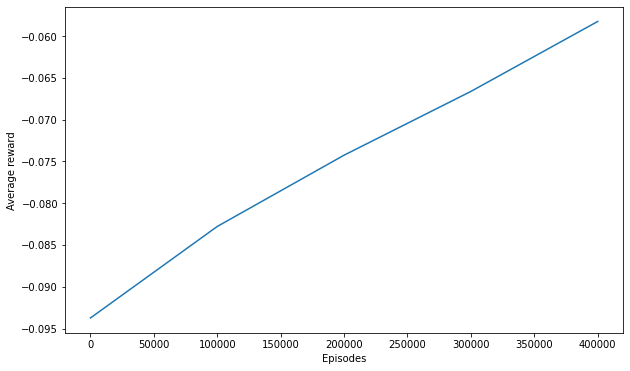

In [ ]:
controller = MonteCarloControl(env)
policy, Q_values = controller.train(500_000)

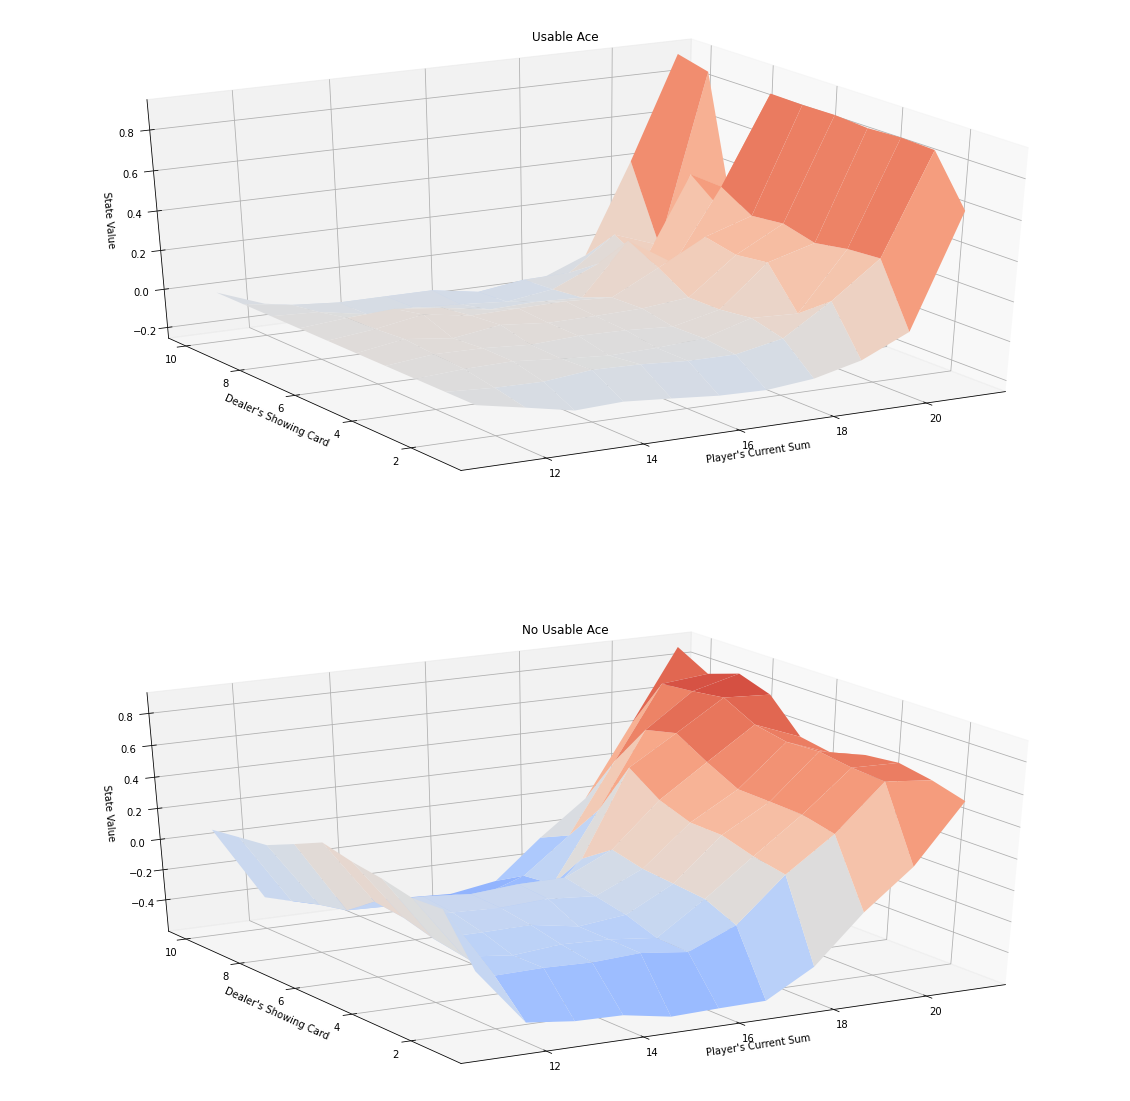

In [ ]:
Q_s = dict((state, np.max(q)) for state, q in Q_values.items())
plot_blackjack_values(Q_s)

# Задание 2

In [17]:
from gym.envs.toy_text import BlackjackEnv
from gym import spaces

In [18]:
class ComplexBlackjack(BlackjackEnv):
    """
      Actions:
      0 - stand
      1 - hit
      2 - double
    """
    def __init__(self):
        super().__init__(natural=True)
        self.action_space = spaces.Discrete(3)
    
    def step(self, action):
      if action == 2:
          next_state, reward, done, _ = self.step(1)
          if done:
              return next_state, 2 * reward, done, {}
          else:
              next_state, reward, done, _, _ = super().step(0)
              return next_state, 2 * reward, done, {}
      else:
        next_state, reward, done, _, _ = super().step(action)
        return next_state, reward, done, {}

Episode num idx=0
Episode num idx=50000
Episode num idx=100000
Episode num idx=150000
Episode num idx=200000
Episode num idx=250000
Episode num idx=300000
Episode num idx=350000
Episode num idx=400000
Episode num idx=450000


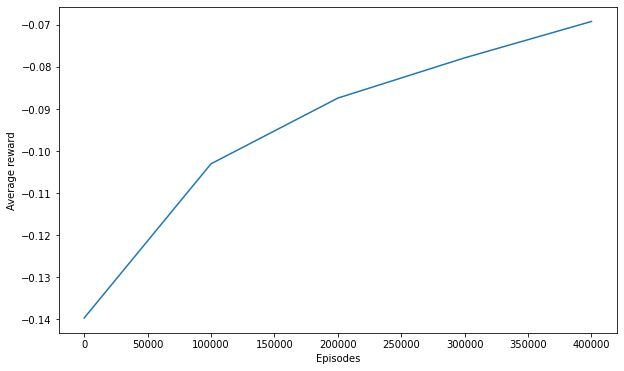

In [ ]:
env = ComplexBlackjack()
controller = MonteCarloControl(env)
policy, Q_values = controller.train(500_000)

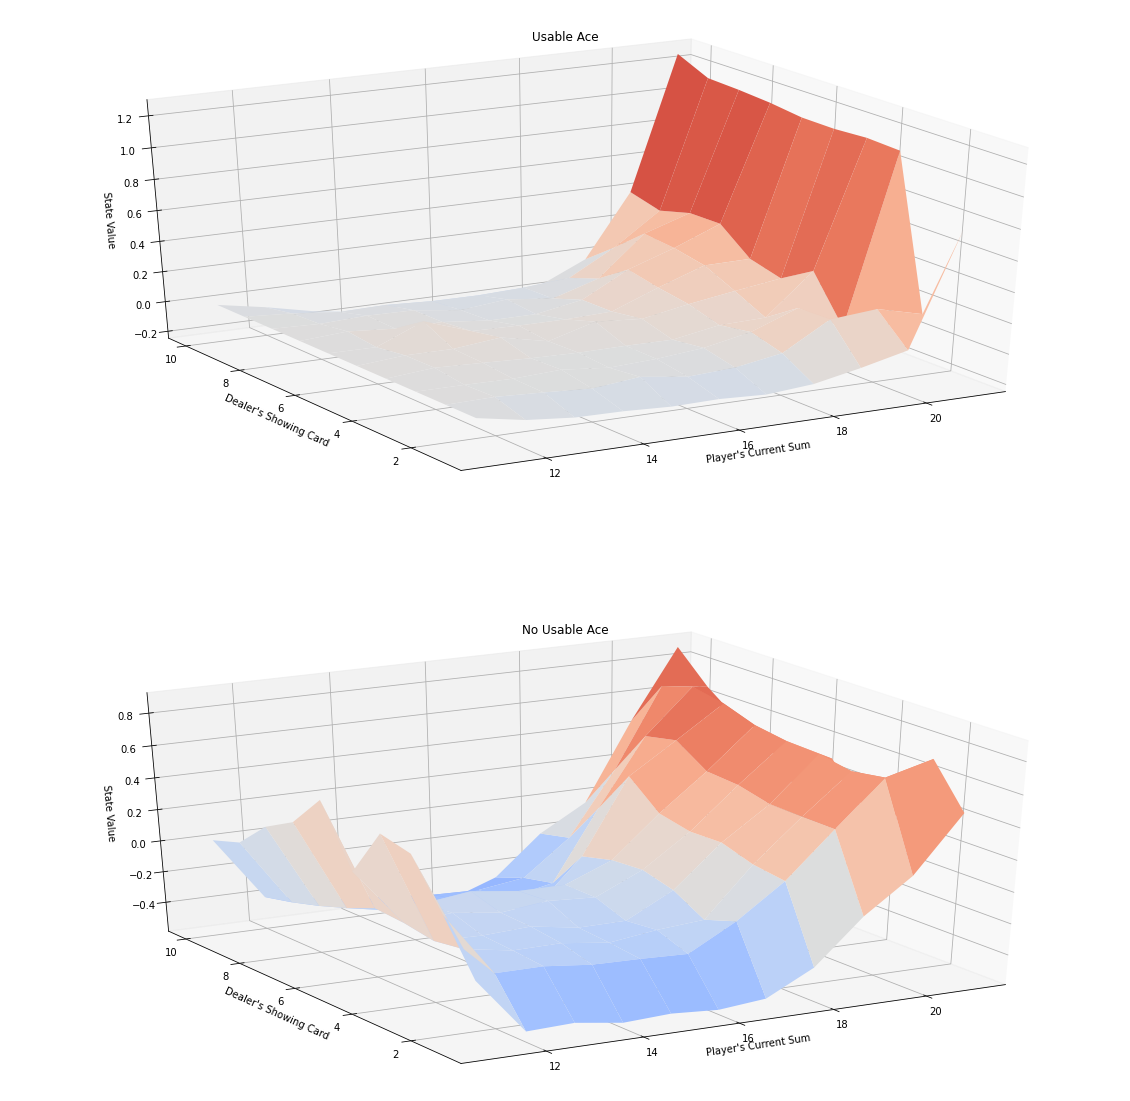

In [ ]:
Q_s = dict((state, np.max(q)) for state, q in Q_values.items())
plot_blackjack_values(Q_s)

# Задание 3
#### Реализуем метод "половинки" на основе числовых значений, которые присваиваются картам.
##### Так как методы в исходниках - внешние, придётся перенести их в класс для переопределения. 

In [41]:
class CheatBlackjack(BlackjackEnv):
  """
      Actions:
      0 - stand
      1 - hit
      2 - double
  """
  HIDDEN_IMPACT = {
      1: -1,
      10: -1,
      9: -.5,
      8: 0,
      2: .5,
      7: .5,
      3: 1,
      4: 1,
      6: 1,
      5: 1.5
  }
  def __init__(self):
      super().__init__(natural=True)
      self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
      self.reset_threshold = 15
      self.counter = 0
      self.reset()

  ### https://github.com/openai/gym/blob/6a04d49722724677610e36c1f92908e72f51da0c/gym/envs/toy_text/blackjack.py#L11
  def cmp(self, a, b):
    return float(a > b) - float(a < b)

  ### https://github.com/openai/gym/blob/6a04d49722724677610e36c1f92908e72f51da0c/gym/envs/toy_text/blackjack.py#L41
  def score(self, hand):  # What is the score of this hand (0 if bust)
    return 0 if self.is_bust(hand) else self.sum_hand(hand)

  ### https://github.com/openai/gym/blob/6a04d49722724677610e36c1f92908e72f51da0c/gym/envs/toy_text/blackjack.py#L19
  def draw_card(self, np_random):
    purposed_card_idx =  np_random.randint(len(self.deck))
    purposed_card = self.deck.pop(purposed_card_idx)
    self.counter += self.HIDDEN_IMPACT[purposed_card]
    return int(purposed_card)

  ### https://github.com/openai/gym/blob/6a04d49722724677610e36c1f92908e72f51da0c/gym/envs/toy_text/blackjack.py#L23
  def draw_hand(self, np_random):
      return [self.draw_card(np_random), self.draw_card(np_random)]
  
  ### https://github.com/openai/gym/blob/6a04d49722724677610e36c1f92908e72f51da0c/gym/envs/toy_text/blackjack.py#L37
  def is_bust(self, hand):
    return self.sum_hand(hand) > 21

  ### https://github.com/openai/gym/blob/6a04d49722724677610e36c1f92908e72f51da0c/gym/envs/toy_text/blackjack.py#L31
  def sum_hand(self, hand):
    if self.usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

  ### https://github.com/openai/gym/blob/6a04d49722724677610e36c1f92908e72f51da0c/gym/envs/toy_text/blackjack.py#L27
  def usable_ace(self, hand):
    return 1 in hand and sum(hand) + 10 <= 21
  
  ### https://github.com/openai/gym/blob/6a04d49722724677610e36c1f92908e72f51da0c/gym/envs/toy_text/blackjack.py#L45
  def is_natural(self, hand):
    return sorted(hand) == [1, 10]
  
  ### https://github.com/openai/gym/blob/6a04d49722724677610e36c1f92908e72f51da0c/gym/envs/toy_text/blackjack.py#L133
  def step(self, action):
      assert self.action_space.contains(action)
      if action:  # hit: add a card to players hand and return
          self.player.append(self.draw_card(self.np_random))
          if self.is_bust(self.player):
              terminated = True
              reward = -1.0
          else:
              terminated = False
              reward = 0.0
      else:  # stick: play out the dealers hand, and score
          terminated = True
          while self.sum_hand(self.dealer) < 17:
              self.dealer.append(self.draw_card(self.np_random))
          reward = self.cmp(self.score(self.player), self.score(self.dealer))
          if self.sab and self.is_natural(self.player) and not self.is_natural(self.dealer):
              # Player automatically wins. Rules consistent with S&B
              reward = 1.0
          elif (
              not self.sab
              and self.natural
              and self.is_natural(self.player)
              and reward == 1.0
          ):
              # Natural gives extra points, but doesn't autowin. Legacy implementation
              reward = 1.5

      if self.render_mode == "human":
          self.render()
      return self._get_obs(), reward, terminated, False, {}

  def _get_obs(self):
      return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player), self.counter)

  def reset(self):
      if len(self.deck) <= self.reset_threshold:
          self.counter = 0
          self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
      
      self.dealer = self.draw_hand(self.np_random)
      self.player = self.draw_hand(self.np_random)
      return self._get_obs()


class ComplexBlackjack(CheatBlackjack):
    """
      Actions:
      0 - stand
      1 - hit
      2 - double
    """
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(3)
    
    def step(self, action):
      if action == 2:
          next_state, reward, done, _ = self.step(1)
          if done:
              return next_state, 2 * reward, done, {}
          else:
              next_state, reward, done, _, _ = super().step(0)
              return next_state, 2 * reward, done, {}
      else:
        next_state, reward, done, _, _ = super().step(action)
        return next_state, reward, done, {}

/usr/local/lib/python3.8/dist-packages/gym/utils/seeding.py:63: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


Episode num idx=0
Episode num idx=50000
Episode num idx=100000
Episode num idx=150000
Episode num idx=200000
Episode num idx=250000
Episode num idx=300000
Episode num idx=350000
Episode num idx=400000
Episode num idx=450000
Episode num idx=500000
Episode num idx=550000
Episode num idx=600000
Episode num idx=650000
Episode num idx=700000
Episode num idx=750000
Episode num idx=800000
Episode num idx=850000
Episode num idx=900000
Episode num idx=950000


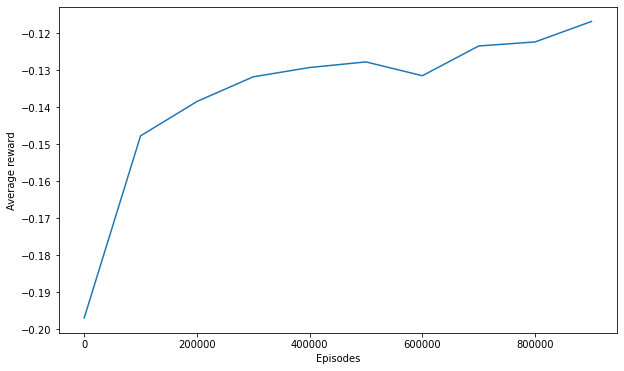

In [44]:
env = ComplexBlackjack()
controller = MonteCarloControl(env)
policy, Q_values = controller.train(1_000_000)